In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import os
import unicodedata
import pickle
import string
import re
import random
import numpy as np
import pdb
from tqdm import tqdm
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
PAD_idx = 0
SOS_idx = 1
EOS_idx = 2
UNK_idx= 3
batch_size = 64
MAX_SENTENCE_LENGTH = 40

In [3]:
en_pretrained_path = './wiki-news-300d-1M.vec'
vi_pretrained_path = './cc.vi.300.vec'

In [4]:
train_en = open('iwslt-vi-en/train.tok.en' , encoding='utf-8').read().strip().split('\n')
val_en = open('iwslt-vi-en/dev.tok.en', encoding='utf-8').read().strip().split('\n')
test_en = open('iwslt-vi-en/test.tok.en', encoding='utf-8').read().strip().split('\n')
train_en[:5]

['Rachel Pike : The science behind a climate headline',
 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .',
 'They are both two branches of the same field of atmospheric science .']

In [5]:
print(len(train_en), len(val_en), len(test_en))

133317 1268 1553


In [5]:
train_vi = open('iwslt-vi-en/train.tok.vi', encoding='utf-8').read().strip().split('\n')
val_vi = open('iwslt-vi-en/dev.tok.vi', encoding='utf-8').read().strip().split('\n')
test_vi = open('iwslt-vi-en/test.tok.vi', encoding='utf-8').read().strip().split('\n')
train_vi[:5]

['Khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'Trong 4 phút , chuyên_gia hoá_học khí_quyển Rachel Pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu , cùng với đoàn nghiên_cứu của mình - - hàng ngàn người đã cống_hiến cho dự_án này - - một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'Tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'Có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu , và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'Cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .']

### Transform data list to dataframe 

In [6]:
def to_dataframe(en, ch, len_raio=0.95):
    en_len_list, ch_len_list = [], []
    for en_sample, ch_sample in zip(en, ch):
        en_len_list.append(len(en_sample))
        ch_len_list.append(len(ch_sample))
    df = pd.DataFrame({'en': en, 
                       'en_len': en_len_list,
                       'ch': ch,
                       'ch_len': ch_len_list
                      })
    en_len_at_ratio = sorted(en_len_list)[int(len_raio*len(en_len_list))]
    ch_len_at_ratio = sorted(ch_len_list)[int(len_raio*len(ch_len_list))]
    print ("EN length @{}: {}, CH length @{}: {}".format(len_raio, en_len_at_ratio, len_raio, ch_len_at_ratio))
    return df, max(en_len_at_ratio, ch_len_at_ratio)

# Data Preprocessing

In [7]:
def load_vectors(fname):
    """
    load the pretrained word embeddings
    param fname: the path the to the word embedding
    return: 
            a dictionary of the {word: embedding}
    """
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [8]:
# Get the vocabulary based on the training data
from collections import Counter

def get_vocabulary(data, VOCABULARY_SIZE=30000):
    
    en_vocab, ch_vocab = [], []
    for idx, row in data.iterrows():
        en_vocab += row['en'].split()
        ch_vocab += row['ch'].split()
    en_token_counter = Counter(en_vocab)
    ch_token_counter = Counter(ch_vocab)
    print ("Number of en words: {}, ch words: {}".format(len(en_token_counter), len(ch_token_counter)))
    en_word, _ = zip(*en_token_counter.most_common(VOCABULARY_SIZE))
    en_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(en_word)
    en_token2id = dict(zip(en_id2token, np.arange(len(en_id2token))))
    ch_word, _ = zip(*ch_token_counter.most_common(VOCABULARY_SIZE))
    ch_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(ch_word)
    ch_token2id = dict(zip(ch_id2token, np.arange(len(ch_id2token))))
    return en_id2token, en_token2id, ch_id2token, ch_token2id

In [9]:
def get_embedding_weights(whole_vec, id2token):
    """
    get the embeddings based on the word, create the embedding matrix
    param whole_vec: the dictionary of pretrained embeddings
    param id2token: the whole vocabulary
    return:
            embedding matrix
    """
    weight = np.zeros((len(id2token), len(whole_vec['sky'])))
    mask = np.zeros((len(id2token)))
    for i, word in enumerate(id2token[1:]):
        if i<3:
            weight[i+1] = np.array(np.random.randn(300))
        elif word in whole_vec.keys():
            weight[i+1] = np.array(whole_vec[word])
        else:
            weight[i+1] = weight[3]
            mask[i+1] = 1
            print ("Out of vocabulary word: ", word)   
    return weight, mask

In [10]:
def load_pickle(data_path, callback, *callback_args):
    """
    Create huge file with the callback function if not exist, otherwise load directly
    param data_path: the path of the load file if exist, otherwise the path to store the created file
    param callback: the function to generate the data if not exist
    param callback_args: the argument for the callback:
    return: 
            the data, either loaded or created by callback
    """

    data_path = data_path
    if os.path.isfile(data_path):
        print ('File exists, load from path...')
        data = pickle.load(open(data_path, 'rb'))
    else:
        print ('File not exists, creating...')
        data = callback(*callback_args)
        pickle.dump(data, open(data_path, 'wb'))
    return data

In [11]:
eng_pretrained = load_pickle('en_pretrained.pkl', load_vectors, en_pretrained_path)
vi_pretrained = load_pickle('vi_pretrained.pkl', load_vectors, vi_pretrained_path)

0it [00:00, ?it/s]

File not exists, creating...


999994it [01:42, 9775.19it/s] 
235it [00:00, 2347.11it/s]

File not exists, creating...


2000000it [03:50, 8663.69it/s]


In [12]:

def normalizeVi(s):
    s = s.lower().strip()
    s =re.sub(r"[-()\"#/@;:<>{}`+=~|,]", "", s)
    s = re.sub(r"[0-9]","",s)
    s = re.sub( '\s+', ' ', s)
    return s

In [13]:
#Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s =' '.join([word.replace('&apos',' ') for word in s.split()])
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [14]:
def token_to_index(sentence, token2id):
    indicies_data = []
    for s in sentence:
        tokens = s.split(' ')
        index_list =[token2id[token] if token in token2id else UNK_idx for token in tokens]
        assert len(tokens) == len(index_list)
        indicies_data.append(index_list)
    return indicies_data


## Enlgish

In [15]:
normalize_train_en = [normalizeString(s) for s in train_en]
normalize_val_en = [normalizeString(s) for s in val_en]
normalize_test_en = [normalizeString(s) for s in test_en]
normalize_train_en[:5]

['rachel pike the science behind a climate headline',
 'in minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'i d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog .',
 'they are both two branches of the same field of atmospheric science .']

## Vietnamese

In [16]:
normalize_train_vi = [normalizeVi(s) for s in train_vi]
normalize_val_vi = [normalizeVi(s) for s in val_vi]
normalize_test_vi = [normalizeVi(s) for s in test_vi]
normalize_train_vi[0]

'khoa_học đằng_sau một tiêu_đề về khí_hậu'

In [17]:
train_df, pad_len = to_dataframe(normalize_train_en, normalize_train_vi)
val_df, _ = to_dataframe(normalize_val_en, normalize_val_vi)
test_df, _ = to_dataframe(normalize_test_en, normalize_test_vi)

EN length @0.95: 228, CH length @0.95: 235
EN length @0.95: 230, CH length @0.95: 238
EN length @0.95: 187, CH length @0.95: 192


In [18]:
en_id2token, en_token2id, vi_id2token, vi_token2id = get_vocabulary(train_df)

Number of en words: 41266, ch words: 33913


In [19]:
train_en_indicies = token_to_index(normalize_train_en, en_token2id)
val_en_indicies = token_to_index(normalize_val_en, en_token2id)
test_en_indicies = token_to_index(normalize_test_en, en_token2id)

In [20]:
train_vi_indicies = token_to_index(normalize_train_vi, vi_token2id)
val_vi_indicies = token_to_index(normalize_val_vi, vi_token2id)
test_vi_indicies = token_to_index(normalize_test_vi, vi_token2id)

In [21]:
train_vi_indicies[0]

[183, 1259, 8, 3129, 29, 807]

In [22]:
print ('-'*100)
eng_embedding, _ = load_pickle('eng_embedding_3.pkl', get_embedding_weights, eng_pretrained, en_id2token)

print ('-'*100)
vi_embedding, _ = load_pickle('vi_embedding_3.pkl', get_embedding_weights, vi_pretrained, vi_id2token)

----------------------------------------------------------------------------------------------------
File not exists, creating...
Out of vocabulary word:  norden
Out of vocabulary word:  rosling
Out of vocabulary word:  tedtalks
Out of vocabulary word:  tedtalk
Out of vocabulary word:  teszler
Out of vocabulary word:  tedglobal
Out of vocabulary word:  ushahidi
Out of vocabulary word:  tedsters
Out of vocabulary word:  tedx
Out of vocabulary word:  lesters
Out of vocabulary word:  lakota
Out of vocabulary word:  nanopatch
Out of vocabulary word:  .q
Out of vocabulary word:  kiribati
Out of vocabulary word:  sobule
Out of vocabulary word:  lesterland
Out of vocabulary word:  tedmed
Out of vocabulary word:  foxo
Out of vocabulary word:  rsw
Out of vocabulary word:  tedwomen
Out of vocabulary word:  gando
Out of vocabulary word:  gehry
Out of vocabulary word:  kibera
Out of vocabulary word:  .j
Out of vocabulary word:  thula
Out of vocabulary word:  tarahumara
Out of vocabulary word:  fmr

Out of vocabulary word:  brynjolfsson
Out of vocabulary word:  pranitha
Out of vocabulary word:  dodi
Out of vocabulary word:  grandin
Out of vocabulary word:  mashelkar
Out of vocabulary word:  leadbeater
Out of vocabulary word:  debora
Out of vocabulary word:  pachycephalosaurus
Out of vocabulary word:  biophony
Out of vocabulary word:  aparna
Out of vocabulary word:  soren
Out of vocabulary word:  damasio
Out of vocabulary word:  verinsky
Out of vocabulary word:  sharmeen
Out of vocabulary word:  liespotters
Out of vocabulary word:  mckinsey
Out of vocabulary word:  parusharam
Out of vocabulary word:  joubert
Out of vocabulary word:  recaptcha
Out of vocabulary word:  heatherwick
Out of vocabulary word:  duflo
Out of vocabulary word:  saima
Out of vocabulary word:  geraldine
Out of vocabulary word:  depthx
Out of vocabulary word:  tandon
Out of vocabulary word:  superbetter
Out of vocabulary word:  yann
Out of vocabulary word:  maasai
Out of vocabulary word:  saks
Out of vocabulary 

Out of vocabulary word:  lehi
Out of vocabulary word:  tunguska
Out of vocabulary word:  burntisland
Out of vocabulary word:  auenbrugger
Out of vocabulary word:  laennec
Out of vocabulary word:  mwenda
Out of vocabulary word:  gottfried
Out of vocabulary word:  mccune
Out of vocabulary word:  outsights
Out of vocabulary word:  culturomics
Out of vocabulary word:  heerden
Out of vocabulary word:  khatanga
Out of vocabulary word:  patternicity
Out of vocabulary word:  patternicities
Out of vocabulary word:  agenticity
Out of vocabulary word:  boniface
Out of vocabulary word:  mwangi
Out of vocabulary word:  stawi
Out of vocabulary word:  radjou
Out of vocabulary word:  megaffic
Out of vocabulary word:  dweck
Out of vocabulary word:  hellum
Out of vocabulary word:  hibridos
Out of vocabulary word:  constitucion
Out of vocabulary word:  fotokite
Out of vocabulary word:  bodnar
Out of vocabulary word:  kanwisher
Out of vocabulary word:  cukier
Out of vocabulary word:  reichental
Out of voc

Out of vocabulary word:  velib
Out of vocabulary word:  argyll
Out of vocabulary word:  tedistan
Out of vocabulary word:  golia
Out of vocabulary word:  sartre
Out of vocabulary word:  otherizing
Out of vocabulary word:  odonil
Out of vocabulary word:  mbubi
Out of vocabulary word:  winona
Out of vocabulary word:  xdrtb
Out of vocabulary word:  epfl
Out of vocabulary word:  foldit
Out of vocabulary word:  goldin
Out of vocabulary word:  olafur
Out of vocabulary word:  iib
Out of vocabulary word:  tedxmidatlantic
Out of vocabulary word:  genji
Out of vocabulary word:  riker
Out of vocabulary word:  smolin
Out of vocabulary word:  bairey
Out of vocabulary word:  marineris
Out of vocabulary word:  hellas
Out of vocabulary word:  arthus
Out of vocabulary word:  nakuru
Out of vocabulary word:  taio
Out of vocabulary word:  mobutu
Out of vocabulary word:  seko
Out of vocabulary word:  abacha
Out of vocabulary word:  zakouma
Out of vocabulary word:  rauf
Out of vocabulary word:  compassionati

Out of vocabulary word:  packbot
Out of vocabulary word:  irobot
Out of vocabulary word:  aethon
Out of vocabulary word:  harbert
Out of vocabulary word:  lanny
Out of vocabulary word:  sommese
Out of vocabulary word:  rapidograph
Out of vocabulary word:  ooooohh
Out of vocabulary word:  sedaris
Out of vocabulary word:  tezuka
Out of vocabulary word:  deckled
Out of vocabulary word:  aomame
Out of vocabulary word:  hanford
Out of vocabulary word:  ettinger
Out of vocabulary word:  eglin
Out of vocabulary word:  photoetched
Out of vocabulary word:  mayes
Out of vocabulary word:  nagel
Out of vocabulary word:  deisseroth
Out of vocabulary word:  fiorella
Out of vocabulary word:  photoactivating
Out of vocabulary word:  halorhodopsins
Out of vocabulary word:  archaerhodopsins
Out of vocabulary word:  horsager
Out of vocabulary word:  jungfrau
Out of vocabulary word:  skysurf
Out of vocabulary word:  joblike
Out of vocabulary word:  couchsurf
Out of vocabulary word:  crowdsurf
Out of vocab

----------------------------------------------------------------------------------------------------
File not exists, creating...
Out of vocabulary word:  chúng_ta
Out of vocabulary word:  có_thể
Out of vocabulary word:  chúng_tôi
Out of vocabulary word:  tất_cả
Out of vocabulary word:  thế_giới
Out of vocabulary word:  thực_sự
Out of vocabulary word:  bắt_đầu
Out of vocabulary word:  vấn_đề
Out of vocabulary word:  thay_đổi
Out of vocabulary word:  sử_dụng
Out of vocabulary word:  bởi_vì
Out of vocabulary word:  thế_nào
Out of vocabulary word:  không_thể
Out of vocabulary word:  bây_giờ
Out of vocabulary word:  đầu_tiên
Out of vocabulary word:  quan_trọng
Out of vocabulary word:  con_người
Out of vocabulary word:  thời_gian
Out of vocabulary word:  phát_triển
Out of vocabulary word:  nghiên_cứu
Out of vocabulary word:  làm_việc
Out of vocabulary word:  có_một
Out of vocabulary word:  tại_sao
Out of vocabulary word:  hệ_thống
Out of vocabulary word:  câu_chuyện
Out of vocabulary word: 

Out of vocabulary word:  kết_luận
Out of vocabulary word:  tài_trợ
Out of vocabulary word:  diễn_thuyết
Out of vocabulary word:  tư_duy
Out of vocabulary word:  chiến_lược
Out of vocabulary word:  sụp_đổ
Out of vocabulary word:  bước_vào
Out of vocabulary word:  chiến_dịch
Out of vocabulary word:  đúng_đắn
Out of vocabulary word:  chữa_trị
Out of vocabulary word:  hơn_cả
Out of vocabulary word:  cà_phê
Out of vocabulary word:  tiêu_chuẩn
Out of vocabulary word:  đi_vào
Out of vocabulary word:  kích_thước
Out of vocabulary word:  vui_vẻ
Out of vocabulary word:  xuất_bản
Out of vocabulary word:  vũ_khí
Out of vocabulary word:  xin_lỗi
Out of vocabulary word:  khởi_đầu
Out of vocabulary word:  dinh_dưỡng
Out of vocabulary word:  nguy_cơ
Out of vocabulary word:  nghe_thấy
Out of vocabulary word:  tiếng_nói
Out of vocabulary word:  năm_qua
Out of vocabulary word:  nông_nghiệp
Out of vocabulary word:  hạt_nhân
Out of vocabulary word:  nhân_loại
Out of vocabulary word:  nhân_tạo
Out of vocabu

Out of vocabulary word:  cô_nàng
Out of vocabulary word:  người_máy
Out of vocabulary word:  thống_trị
Out of vocabulary word:  câu_lạc_bộ
Out of vocabulary word:  nổi_lên
Out of vocabulary word:  nhảy_múa
Out of vocabulary word:  nói_gì
Out of vocabulary word:  đến_nơi
Out of vocabulary word:  trước_kia
Out of vocabulary word:  thích_ứng
Out of vocabulary word:  ban_đêm
Out of vocabulary word:  thời_khắc
Out of vocabulary word:  chi_tiêu
Out of vocabulary word:  tổng_thể
Out of vocabulary word:  tư_vấn
Out of vocabulary word:  quá_mức
Out of vocabulary word:  chắc_là
Out of vocabulary word:  ra_mắt
Out of vocabulary word:  bánh_xe
Out of vocabulary word:  khán_phòng
Out of vocabulary word:  hấp_thụ
Out of vocabulary word:  xét_nghiệm
Out of vocabulary word:  đỉnh_cao
Out of vocabulary word:  đói_nghèo
Out of vocabulary word:  thể_chế
Out of vocabulary word:  phản_chiếu
Out of vocabulary word:  kỷ_lục
Out of vocabulary word:  doanh_nhân
Out of vocabulary word:  hiệu_suất
Out of vocabul

Out of vocabulary word:  có_giá
Out of vocabulary word:  bình_quân
Out of vocabulary word:  hoá_đơn
Out of vocabulary word:  giết_người
Out of vocabulary word:  ám_chỉ
Out of vocabulary word:  tha_thứ
Out of vocabulary word:  hợp_xướng
Out of vocabulary word:  bạn_đời
Out of vocabulary word:  tính_năng
Out of vocabulary word:  ảo_ảnh
Out of vocabulary word:  độc_nhất
Out of vocabulary word:  làn_sóng
Out of vocabulary word:  sinh_lý
Out of vocabulary word:  nhỏ_xíu
Out of vocabulary word:  hằng_ngày
Out of vocabulary word:  khẩn_cấp
Out of vocabulary word:  đôi_chút
Out of vocabulary word:  đám_cưới
Out of vocabulary word:  hy_sinh
Out of vocabulary word:  lưu_thông
Out of vocabulary word:  chống_đối
Out of vocabulary word:  coi_trọng
Out of vocabulary word:  bất_công
Out of vocabulary word:  cứu_trợ
Out of vocabulary word:  đại_chúng
Out of vocabulary word:  tuỳ_thuộc
Out of vocabulary word:  núi_lửa
Out of vocabulary word:  hồi_sinh
Out of vocabulary word:  đường_thẳng
Out of vocabul

Out of vocabulary word:  đồng_phục
Out of vocabulary word:  ly_dị
Out of vocabulary word:  nghe_tiếng
Out of vocabulary word:  trùng_hợp
Out of vocabulary word:  khép_kín
Out of vocabulary word:  chênh_lệch
Out of vocabulary word:  bảo_trợ
Out of vocabulary word:  sao_thổ
Out of vocabulary word:  tai_nghe
Out of vocabulary word:  nhờ_có
Out of vocabulary word:  cách_ly
Out of vocabulary word:  nuôi_trồng
Out of vocabulary word:  trung_cổ
Out of vocabulary word:  trai_trẻ
Out of vocabulary word:  kiểm_nghiệm
Out of vocabulary word:  dối_trá
Out of vocabulary word:  đồ_sộ
Out of vocabulary word:  nghĩa_vụ
Out of vocabulary word:  tasmanian
Out of vocabulary word:  bất_ổn
Out of vocabulary word:  đười_ươi
Out of vocabulary word:  huy_chương
Out of vocabulary word:  tàn_sát
Out of vocabulary word:  viễn_khách
Out of vocabulary word:  cơ_đốc
Out of vocabulary word:  năm_năm
Out of vocabulary word:  chết_giả
Out of vocabulary word:  ushahidi
Out of vocabulary word:  cẩn_trọng
Out of vocabula

Out of vocabulary word:  yên_tâm
Out of vocabulary word:  sân_sau
Out of vocabulary word:  thường_lệ
Out of vocabulary word:  hồi_tưởng
Out of vocabulary word:  làm_xong
Out of vocabulary word:  diễn_xuất
Out of vocabulary word:  vừa_vặn
Out of vocabulary word:  chạy_theo
Out of vocabulary word:  bỗng_dưng
Out of vocabulary word:  biết_đâu
Out of vocabulary word:  rác_rưởi
Out of vocabulary word:  ii.
Out of vocabulary word:  ba_mẹ
Out of vocabulary word:  cục_bộ
Out of vocabulary word:  nản_lòng
Out of vocabulary word:  hiện_thời
Out of vocabulary word:  ngừng_bắn
Out of vocabulary word:  bầu_dục
Out of vocabulary word:  chung_cư
Out of vocabulary word:  linh_tinh
Out of vocabulary word:  không_quân
Out of vocabulary word:  hành_quân
Out of vocabulary word:  tụ_họp
Out of vocabulary word:  nguyên_vật_liệu
Out of vocabulary word:  khởi_điểm
Out of vocabulary word:  phân_tách
Out of vocabulary word:  không_mấy
Out of vocabulary word:  lộ_trình
Out of vocabulary word:  giả_mạo
Out of voc

Out of vocabulary word:  gật_đầu
Out of vocabulary word:  rập_khuôn
Out of vocabulary word:  da_trời
Out of vocabulary word:  chơi_chữ
Out of vocabulary word:  lắc_lư
Out of vocabulary word:  hoá_thân
Out of vocabulary word:  phong_bì
Out of vocabulary word:  mạng_nhện
Out of vocabulary word:  có_số
Out of vocabulary word:  tinh_xảo
Out of vocabulary word:  tuyển_cử
Out of vocabulary word:  cánh_hữu
Out of vocabulary word:  bãi_bỏ
Out of vocabulary word:  thường_thường
Out of vocabulary word:  cổ_họng
Out of vocabulary word:  vội_vã
Out of vocabulary word:  gapminder
Out of vocabulary word:  đọc_bài
Out of vocabulary word:  một_độ
Out of vocabulary word:  nhất_thời
Out of vocabulary word:  số_nhiều
Out of vocabulary word:  cá_cược
Out of vocabulary word:  triệu_triệu
Out of vocabulary word:  thiên_thể
Out of vocabulary word:  dương_cầm
Out of vocabulary word:  du_mục
Out of vocabulary word:  uỷ_thác
Out of vocabulary word:  hiện_thân
Out of vocabulary word:  bộ_môn
Out of vocabulary wo

Out of vocabulary word:  nấc_cụt
Out of vocabulary word:  luria
Out of vocabulary word:  bò_sát
Out of vocabulary word:  vé_số
Out of vocabulary word:  kiểu_dáng
Out of vocabulary word:  tháng_ba
Out of vocabulary word:  tối_giản
Out of vocabulary word:  cấm_đoán
Out of vocabulary word:  phun_trào
Out of vocabulary word:  phô_bày
Out of vocabulary word:  nguyện_vọng
Out of vocabulary word:  vi_trùng
Out of vocabulary word:  trang_điểm
Out of vocabulary word:  tái_diễn
Out of vocabulary word:  pauling
Out of vocabulary word:  thường_dân
Out of vocabulary word:  sửa_lại
Out of vocabulary word:  tiêu_cự
Out of vocabulary word:  đánh_cược
Out of vocabulary word:  giai_cấp
Out of vocabulary word:  giáo_đường
Out of vocabulary word:  tự_mãn
Out of vocabulary word:  giá_như
Out of vocabulary word:  song_hành
Out of vocabulary word:  phim_truyền_hình
Out of vocabulary word:  hướng_dương
Out of vocabulary word:  tulu
Out of vocabulary word:  ống_hút
Out of vocabulary word:  điên_loạn
Out of voc

Out of vocabulary word:  đình_trệ
Out of vocabulary word:  cho_được
Out of vocabulary word:  xem_ra
Out of vocabulary word:  đẹp_mắt
Out of vocabulary word:  thời_chiến
Out of vocabulary word:  không_tên
Out of vocabulary word:  cằn_cỗi
Out of vocabulary word:  mai_sau
Out of vocabulary word:  che_mắt
Out of vocabulary word:  bình_thản
Out of vocabulary word:  tử_tù
Out of vocabulary word:  nói_lắp
Out of vocabulary word:  ước_mong
Out of vocabulary word:  ornish
Out of vocabulary word:  vừa_nãy
Out of vocabulary word:  đi_đôi
Out of vocabulary word:  khí_đốt
Out of vocabulary word:  làm_trò
Out of vocabulary word:  ốc_sên
Out of vocabulary word:  nhún_nhường
Out of vocabulary word:  đồ_án
Out of vocabulary word:  tuyển_chọn
Out of vocabulary word:  suy_tàn
Out of vocabulary word:  bộ_binh
Out of vocabulary word:  đầu_bò
Out of vocabulary word:  đập_cánh
Out of vocabulary word:  làng_mạc
Out of vocabulary word:  phong_kiến
Out of vocabulary word:  góc_phố
Out of vocabulary word:  usain

Out of vocabulary word:  náo_động
Out of vocabulary word:  có_thể_nào
Out of vocabulary word:  dị_thường
Out of vocabulary word:  hành_trang
Out of vocabulary word:  lửa_trại
Out of vocabulary word:  kế_sách
Out of vocabulary word:  bảng_đen
Out of vocabulary word:  nước_lên
Out of vocabulary word:  lưỡng_lự
Out of vocabulary word:  chạy_của
Out of vocabulary word:  tái_bản
Out of vocabulary word:  thép_không_gỉ
Out of vocabulary word:  chữ_nổi
Out of vocabulary word:  pháo_đài
Out of vocabulary word:  chứng_cớ
Out of vocabulary word:  thượng_nguồn
Out of vocabulary word:  nhen_nhóm
Out of vocabulary word:  đèn_pha
Out of vocabulary word:  sinh_tố
Out of vocabulary word:  đĩa_hát
Out of vocabulary word:  orwell
Out of vocabulary word:  truy_lùng
Out of vocabulary word:  mêhicô
Out of vocabulary word:  truyền_dẫn
Out of vocabulary word:  nam_nữ
Out of vocabulary word:  sarkozy
Out of vocabulary word:  tô_vẽ
Out of vocabulary word:  đi_ở
Out of vocabulary word:  suy_đồi
Out of vocabulary

Out of vocabulary word:  vượn_người
Out of vocabulary word:  cầm_nắm
Out of vocabulary word:  lessig
Out of vocabulary word:  vừa_lòng
Out of vocabulary word:  môi_trường_học
Out of vocabulary word:  phó_tổng_thống
Out of vocabulary word:  kỳ_hạn
Out of vocabulary word:  vỏ_sò
Out of vocabulary word:  bản_lưu
Out of vocabulary word:  đại_lục
Out of vocabulary word:  năm_ánh_sáng
Out of vocabulary word:  kêu_cứu
Out of vocabulary word:  đại_hội
Out of vocabulary word:  bom_đạn
Out of vocabulary word:  bùng_binh
Out of vocabulary word:  thương_tật
Out of vocabulary word:  tuần_tự
Out of vocabulary word:  bắt_đầu_đọc
Out of vocabulary word:  bòng_bong
Out of vocabulary word:  giấy_báo
Out of vocabulary word:  trí_khôn
Out of vocabulary word:  cho_không
Out of vocabulary word:  soi_sáng
Out of vocabulary word:  kia_mà
Out of vocabulary word:  nhà_chứa
Out of vocabulary word:  danh_bạ
Out of vocabulary word:  hắt_hơi
Out of vocabulary word:  béo_bở
Out of vocabulary word:  ra_vẻ
Out of voca

Out of vocabulary word:  hết_lòng
Out of vocabulary word:  âm_vực
Out of vocabulary word:  giữ_chặt
Out of vocabulary word:  da_đầu
Out of vocabulary word:  xôn_xao
Out of vocabulary word:  nhiệt_từ
Out of vocabulary word:  trăm_sự
Out of vocabulary word:  bừa_bộn
Out of vocabulary word:  whewell
Out of vocabulary word:  trấn_tĩnh
Out of vocabulary word:  thời_giờ
Out of vocabulary word:  quy_nạp
Out of vocabulary word:  ngăn_cấm
Out of vocabulary word:  có_lẽ_nào
Out of vocabulary word:  cực_mạnh
Out of vocabulary word:  sửa_sang
Out of vocabulary word:  quy_cách
Out of vocabulary word:  gia_sản
Out of vocabulary word:  cẩm_thạch
Out of vocabulary word:  hợp_kim
Out of vocabulary word:  học_kì
Out of vocabulary word:  thuyết_darwin
Out of vocabulary word:  hồ_nghi
Out of vocabulary word:  ứng_cử_viên
Out of vocabulary word:  thoreau
Out of vocabulary word:  quy_chế
Out of vocabulary word:  nhận_chìm
Out of vocabulary word:  cực_đại
Out of vocabulary word:  quá_giang
Out of vocabulary 

Out of vocabulary word:  ăn_tạp
Out of vocabulary word:  màng_xương
Out of vocabulary word:  perony
Out of vocabulary word:  quần_hợp
Out of vocabulary word:  cá_ngựa
Out of vocabulary word:  tụ_hội
Out of vocabulary word:  cực_ngắn
Out of vocabulary word:  tích_phân
Out of vocabulary word:  tiểu_mục
Out of vocabulary word:  filmclub
Out of vocabulary word:  thú_tính
Out of vocabulary word:  tranh_đua
Out of vocabulary word:  kẻ_cướp
Out of vocabulary word:  gia_truyền
Out of vocabulary word:  báo_giới
Out of vocabulary word:  geert
Out of vocabulary word:  tròn_trịa
Out of vocabulary word:  fedeli
Out of vocabulary word:  ổ_đĩa
Out of vocabulary word:  kinh_hồn
Out of vocabulary word:  kim_khí
Out of vocabulary word:  làm_đau
Out of vocabulary word:  cbgb
Out of vocabulary word:  ít_lâu
Out of vocabulary word:  dội_âm
Out of vocabulary word:  rườm_rà
Out of vocabulary word:  kêu_la
Out of vocabulary word:  mahler
Out of vocabulary word:  rút_cục
Out of vocabulary word:  vũ_đài
Out of 

Out of vocabulary word:  liệt_dương
Out of vocabulary word:  quí_bà
Out of vocabulary word:  đình_đám
Out of vocabulary word:  duy_vật
Out of vocabulary word:  chia_phần
Out of vocabulary word:  ăn_học
Out of vocabulary word:  du_cư
Out of vocabulary word:  người_quản_lí
Out of vocabulary word:  bloggs
Out of vocabulary word:  bbc.
Out of vocabulary word:  cavendish
Out of vocabulary word:  rosalind
Out of vocabulary word:  arn.
Out of vocabulary word:  cứu_bệnh
Out of vocabulary word:  đa_giác
Out of vocabulary word:  mù_tạt
Out of vocabulary word:  gopnik
Out of vocabulary word:  cá_vàng
Out of vocabulary word:  nhấm_nháp
Out of vocabulary word:  hồi_lâu
Out of vocabulary word:  cristine
Out of vocabulary word:  trung_khu
Out of vocabulary word:  trăm_tuổi
Out of vocabulary word:  kẻ_ô
Out of vocabulary word:  kymaerica
Out of vocabulary word:  tàu_lá
Out of vocabulary word:  sắp_hàng
Out of vocabulary word:  gbm.
Out of vocabulary word:  gây_nhiễu
Out of vocabulary word:  dây_cương


Out of vocabulary word:  nicolaus
Out of vocabulary word:  đình_công_của
Out of vocabulary word:  tẩy_xoá
Out of vocabulary word:  cơn_sốt
Out of vocabulary word:  spect
Out of vocabulary word:  kibaki
Out of vocabulary word:  chống_cự
Out of vocabulary word:  hiếu_chiến
Out of vocabulary word:  spittin
Out of vocabulary word:  trình_báo
Out of vocabulary word:  heuser
Out of vocabulary word:  chladni
Out of vocabulary word:  lxd
Out of vocabulary word:  đoán_chừng
Out of vocabulary word:  denisovans
Out of vocabulary word:  bừng_tỉnh
Out of vocabulary word:  bệnh_án
Out of vocabulary word:  icu
Out of vocabulary word:  beckstrom
Out of vocabulary word:  mybo
Out of vocabulary word:  shree
Out of vocabulary word:  quanh_năm
Out of vocabulary word:  ntaiya
Out of vocabulary word:  maasais
Out of vocabulary word:  bharti
Out of vocabulary word:  dassen
Out of vocabulary word:  chú_rể
Out of vocabulary word:  greenspan
Out of vocabulary word:  rtpj
Out of vocabulary word:  điều_tra_viên
O

Out of vocabulary word:  nằm_viện
Out of vocabulary word:  tươi_trẻ
Out of vocabulary word:  không_bào
Out of vocabulary word:  cửa_ra_vào
Out of vocabulary word:  tedprize
Out of vocabulary word:  ramallah
Out of vocabulary word:  tuỳ_thân
Out of vocabulary word:  kháng_khuẩn
Out of vocabulary word:  diêm_vương_tinh
Out of vocabulary word:  raptopoulos
Out of vocabulary word:  matternet
Out of vocabulary word:  bệnh_phẩm
Out of vocabulary word:  đồng_bộ_hoá
Out of vocabulary word:  luyến_tiếc
Out of vocabulary word:  dung_sai
Out of vocabulary word:  fiorenzo
Out of vocabulary word:  đậm_nét
Out of vocabulary word:  đa_dụng
Out of vocabulary word:  aamodt
Out of vocabulary word:  pariser
Out of vocabulary word:  xử_thế
Out of vocabulary word:  con_sa
Out of vocabulary word:  bóng_vía
Out of vocabulary word:  đái_tháo
Out of vocabulary word:  phiền_não
Out of vocabulary word:  cụ_già
Out of vocabulary word:  hoại_tử
Out of vocabulary word:  jebr
Out of vocabulary word:  biddle
Out of v

Out of vocabulary word:  keck
Out of vocabulary word:  trắng_tay
Out of vocabulary word:  sharman
Out of vocabulary word:  trang_nghiêm
Out of vocabulary word:  lucianne
Out of vocabulary word:  walkowicz
Out of vocabulary word:  tử_ngoại
Out of vocabulary word:  kéré
Out of vocabulary word:  khẩn_trương
Out of vocabulary word:  christo
Out of vocabulary word:  posada
Out of vocabulary word:  bám_trụ
Out of vocabulary word:  hay_làm_việc
Out of vocabulary word:  ngã_ngũ
Out of vocabulary word:  vượt_cạn
Out of vocabulary word:  lạc_lõng
Out of vocabulary word:  krastev
Out of vocabulary word:  li_hôn
Out of vocabulary word:  bất_tín_nhiệm
Out of vocabulary word:  alanna
Out of vocabulary word:  shaikh
Out of vocabulary word:  duncker
Out of vocabulary word:  glucksberg
Out of vocabulary word:  madurai
Out of vocabulary word:  tzemach
Out of vocabulary word:  lemmon
Out of vocabulary word:  lận_đận
Out of vocabulary word:  cải_biến
Out of vocabulary word:  dây_lưng
Out of vocabulary wor

Out of vocabulary word:  ở_ẩn
Out of vocabulary word:  chật_cứng
Out of vocabulary word:  tròng_trắng
Out of vocabulary word:  mafundikwa
Out of vocabulary word:  đa_âm
Out of vocabulary word:  siera
Out of vocabulary word:  cheikh
Out of vocabulary word:  đường_chỉ
Out of vocabulary word:  duluth
Out of vocabulary word:  giun_đất
Out of vocabulary word:  ống_khí
Out of vocabulary word:  cầu_ô
Out of vocabulary word:  thoáng_khí
Out of vocabulary word:  ikaria
Out of vocabulary word:  griscom
Out of vocabulary word:  chiếu_rọi
Out of vocabulary word:  ngã_nhào
Out of vocabulary word:  nhị_nguyên
Out of vocabulary word:  tủi_hổ
Out of vocabulary word:  hrabowski
Out of vocabulary word:  umbc
Out of vocabulary word:  học_sinh_từ
Out of vocabulary word:  bồng_bột
Out of vocabulary word:  meyerhoff
Out of vocabulary word:  cilliers
Out of vocabulary word:  ngọn_ngành
Out of vocabulary word:  ống_thổi
Out of vocabulary word:  công_ích
Out of vocabulary word:  leded
Out of vocabulary word:  

Out of vocabulary word:  tái_giá
Out of vocabulary word:  janette
Out of vocabulary word:  măng_tây
Out of vocabulary word:  cappadoccia
Out of vocabulary word:  ogami
Out of vocabulary word:  shehab
Out of vocabulary word:  quân_luật
Out of vocabulary word:  hemmert
Out of vocabulary word:  tedxberlin
Out of vocabulary word:  bảo_trọng
Out of vocabulary word:  josette
Out of vocabulary word:  cnn.
Out of vocabulary word:  hành_tây
Out of vocabulary word:  bao_giờ_ăn
Out of vocabulary word:  đã_vậy
Out of vocabulary word:  connolly
Out of vocabulary word:  yutaka
Out of vocabulary word:  shimura
Out of vocabulary word:  con_đẻ
Out of vocabulary word:  shilale
Out of vocabulary word:  dietz
Out of vocabulary word:  swazey
Out of vocabulary word:  trâu_bò
Out of vocabulary word:  trần_thuật
Out of vocabulary word:  ngây_ngất
Out of vocabulary word:  whipcar
Out of vocabulary word:  cử_ai
Out of vocabulary word:  nghiệp_vụ
Out of vocabulary word:  nhộn_nhịp
Out of vocabulary word:  phảng_

Out of vocabulary word:  peeters
Out of vocabulary word:  nguyên_dạng
Out of vocabulary word:  pcch.
Out of vocabulary word:  một_số_liệu
Out of vocabulary word:  long_trọng
Out of vocabulary word:  mối_mọt
Out of vocabulary word:  thành_đô
Out of vocabulary word:  domigo
Out of vocabulary word:  onagawa
Out of vocabulary word:  tách_tách
Out of vocabulary word:  kinh_tuyến
Out of vocabulary word:  thảm_thiết
Out of vocabulary word:  giấc_ngủ_ngon
Out of vocabulary word:  xích_đu
Out of vocabulary word:  cực_hình
Out of vocabulary word:  trảl
Out of vocabulary word:  ngộ_đạo
Out of vocabulary word:  biệt_lệ
Out of vocabulary word:  bưng_bít
Out of vocabulary word:  gió_lốc
Out of vocabulary word:  nghèo_túng
Out of vocabulary word:  thiên_tư
Out of vocabulary word:  dâm_dục
Out of vocabulary word:  dưỡng_sức
Out of vocabulary word:  viện_phó
Out of vocabulary word:  tỉnh_ngộ
Out of vocabulary word:  fallor
Out of vocabulary word:  lẻ_bạn
Out of vocabulary word:  tự_hình
Out of vocabula

Out of vocabulary word:  sekulos
Out of vocabulary word:  địa_tâm
Out of vocabulary word:  baleful
Out of vocabulary word:  avaricious
Out of vocabulary word:  caruso
Out of vocabulary word:  bessie
Out of vocabulary word:  thuốc_thử
Out of vocabulary word:  đặc_hữu
Out of vocabulary word:  ngân_quĩ
Out of vocabulary word:  đồng_áng
Out of vocabulary word:  hiếu_thảo
Out of vocabulary word:  ít_tuổi
Out of vocabulary word:  dưỡng_già
Out of vocabulary word:  đái_đường
Out of vocabulary word:  bpa.
Out of vocabulary word:  nặng_như_chì
Out of vocabulary word:  foocmađêhít
Out of vocabulary word:  ướp_xác
Out of vocabulary word:  myles
Out of vocabulary word:  stirton
Out of vocabulary word:  arlington
Out of vocabulary word:  ọp_ẹp
Out of vocabulary word:  rucell
Out of vocabulary word:  nội_ô
Out of vocabulary word:  kế_toán_trưởng
Out of vocabulary word:  ly_khai
Out of vocabulary word:  venable
Out of vocabulary word:  cunxg
Out of vocabulary word:  phân_đội
Out of vocabulary word:  

Out of vocabulary word:  nhà_tư
Out of vocabulary word:  brathwaite
Out of vocabulary word:  brathwife
Out of vocabulary word:  tedxphoenix
Out of vocabulary word:  xạ_thủ
Out of vocabulary word:  buzzwords
Out of vocabulary word:  đổ_bệnh
Out of vocabulary word:  síochán
Out of vocabulary word:  leat
Out of vocabulary word:  têntrain
Out of vocabulary word:  chung_qui
Out of vocabulary word:  caucasians
Out of vocabulary word:  hispanics
Out of vocabulary word:  extremo
Out of vocabulary word:  tater
Out of vocabulary word:  eatwise
Out of vocabulary word:  tarts
Out of vocabulary word:  hết_hơi
Out of vocabulary word:  hao_phí
Out of vocabulary word:  cháy_nắng
Out of vocabulary word:  hoả_mai
Out of vocabulary word:  thucjw
Out of vocabulary word:  tỉnh_lỵ
Out of vocabulary word:  albany
Out of vocabulary word:  harrisburg
Out of vocabulary word:  đã_dễ
Out of vocabulary word:  irishman
Out of vocabulary word:  sowell
Out of vocabulary word:  wechsler
Out of vocabulary word:  thiết_

Out of vocabulary word:  wehba
Out of vocabulary word:  nayef
Out of vocabulary word:  mutawa
Out of vocabulary word:  noora
Out of vocabulary word:  nhiệt_học
Out of vocabulary word:  carre
Out of vocabulary word:  crosley
Out of vocabulary word:  icyball
Out of vocabulary word:  bình_ngưng
Out of vocabulary word:  công_nợ
Out of vocabulary word:  vậy_mà_thôi
Out of vocabulary word:  mật_chỉ
Out of vocabulary word:  phát_nguyên
Out of vocabulary word:  thịnh_đạt
Out of vocabulary word:  nghèo_túng_nhiên_liệu
Out of vocabulary word:  ekhayelitsha
Out of vocabulary word:  khốn_nỗi
Out of vocabulary word:  trình_độ_cao
Out of vocabulary word:  paraorchestra
Out of vocabulary word:  sự_tình
Out of vocabulary word:  mang_danh
Out of vocabulary word:  cơ_tự
Out of vocabulary word:  berkenstocks
Out of vocabulary word:  mukhopadhyay
Out of vocabulary word:  gia_giáo
Out of vocabulary word:  maricela
Out of vocabulary word:  nứt_nẻ
Out of vocabulary word:  dỗ_dành
Out of vocabulary word:  tal

Out of vocabulary word:  brescianini
Out of vocabulary word:  hehn
Out of vocabulary word:  chỉ_tơ
Out of vocabulary word:  kẽ_răng
Out of vocabulary word:  bắp_ngô
Out of vocabulary word:  havidol
Out of vocabulary word:  woloshin
Out of vocabulary word:  hay_đâu
Out of vocabulary word:  tufte
Out of vocabulary word:  ldl.
Out of vocabulary word:  crp.
Out of vocabulary word:  labcorp
Out of vocabulary word:  thụ_tinh_thành
Out of vocabulary word:  bayridge
Out of vocabulary word:  tevas
Out of vocabulary word:  đồng_thời_sự
Out of vocabulary word:  cái_bè
Out of vocabulary word:  diễu_binh
Out of vocabulary word:  nửa_mùa
Out of vocabulary word:  rệu_rã
Out of vocabulary word:  sâu_sát
Out of vocabulary word:  wittgenstein
Out of vocabulary word:  tedxboston
Out of vocabulary word:  bỏ_ăn
Out of vocabulary word:  đẳng_vị
Out of vocabulary word:  avpr
Out of vocabulary word:  truy_thu
Out of vocabulary word:  bố_đẻ
Out of vocabulary word:  hổ_lốn
Out of vocabulary word:  mantegna
Out 

Out of vocabulary word:  covey
Out of vocabulary word:  thơm_tho
Out of vocabulary word:  con_nước
Out of vocabulary word:  gầy_còm
Out of vocabulary word:  độ_vĩ
Out of vocabulary word:  furchgott
Out of vocabulary word:  ignarro
Out of vocabulary word:  cứu_sinh_viên
Out of vocabulary word:  thiên_đỉnh
Out of vocabulary word:  thắng_cuộc_chơi
Out of vocabulary word:  habf
Out of vocabulary word:  kỳ_thực_chất
Out of vocabulary word:  vụ_án_từ
Out of vocabulary word:  moneyballing
Out of vocabulary word:  đại_thụ
Out of vocabulary word:  sequoiadendron
Out of vocabulary word:  độngmà
Out of vocabulary word:  mộtkiểu
Out of vocabulary word:  rễ_con
Out of vocabulary word:  scharf
Out of vocabulary word:  borghese
Out of vocabulary word:  có_trở
Out of vocabulary word:  thânphilips
Out of vocabulary word:  chải_chuốt
Out of vocabulary word:  tông_đồ
Out of vocabulary word:  khăn_lau
Out of vocabulary word:  giãi_bày
Out of vocabulary word:  athen
Out of vocabulary word:  có_tật
Out of v

Out of vocabulary word:  hartsdale
Out of vocabulary word:  sóng_triều
Out of vocabulary word:  mortha
Out of vocabulary word:  giẫm_đạp
Out of vocabulary word:  lố_lăng
Out of vocabulary word:  tác_chiến
Out of vocabulary word:  kế_nhiệm
Out of vocabulary word:  trò_cười
Out of vocabulary word:  què_quặt
Out of vocabulary word:  bandunda
Out of vocabulary word:  theo_thời_gian
Out of vocabulary word:  lập_loè
Out of vocabulary word:  tướng_lĩnh
Out of vocabulary word:  diễn_kịch
Out of vocabulary word:  xa_gần
Out of vocabulary word:  máy_chiếu_phim
Out of vocabulary word:  cây_vợt
Out of vocabulary word:  nói_suông
Out of vocabulary word:  quản_chế
Out of vocabulary word:  xuất_ngoại
Out of vocabulary word:  quân_chủng
Out of vocabulary word:  urruela
Out of vocabulary word:  vetsports
Out of vocabulary word:  duckworth
Out of vocabulary word:  mcenroe
Out of vocabulary word:  chứng_minh_điều
Out of vocabulary word:  tổng_số_lượng
Out of vocabulary word:  tytôi
Out of vocabulary word

In [23]:
vi_embedding.shape

(30004, 300)

## Data Loader

In [24]:
class LanguageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, source_lan, translate_lan):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source_lan = source_lan
        self.translate_lan = translate_lan
        
        assert (len(self.source_lan) == len(self.translate_lan))

    def __len__(self):
        return len(self.source_lan)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        source_lan_idx = self.source_lan[key][:MAX_SENTENCE_LENGTH-1]
        translation_lan_idx = self.translate_lan[key][:MAX_SENTENCE_LENGTH-1]
        source_lan_idx.append(EOS_idx)
        translation_lan_idx.append(EOS_idx)
        
        return [source_lan_idx, translation_lan_idx, len(source_lan_idx), len(translation_lan_idx)]


In [25]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    translate_list = []
    length_list = []
    
    # padding
    for datum in batch:
        
        length_list.append(datum[2])
        s_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=PAD_idx)
        source_list.append(s_padded_vec)
        t_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=PAD_idx)
        translate_list.append(t_padded_vec)
        
    ind_dec_order = np.argsort(length_list)[::-1]
    source_list = np.array(source_list)[ind_dec_order]
    length_list = np.array(length_list)[ind_dec_order]
    translate_list = np.array(translate_list)[ind_dec_order]
    
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(source_list)).cuda(),torch.from_numpy(np.array(translate_list)).cuda()]
    else:
        return [torch.from_numpy(np.array(source_list)),torch.from_numpy(np.array(translate_list))]




In [26]:
#Build train, valid and test dataloaders
train_dataset = LanguageDataset(train_vi_indicies, train_en_indicies)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


val_dataset = LanguageDataset(val_vi_indicies, val_en_indicies )
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = LanguageDataset(test_vi_indicies, test_en_indicies)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


## Rnn Encoder

In [27]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(vi_embedding), freeze=False)
        
        self.dropout = nn.Dropout(p=0.3)
        self.gru = nn.GRU(emb_dim, self.hid_dim, batch_first=True, bidirectional= True)
        

    def forward(self, inputs, hidden):
        batch_size, length = inputs.size()
        embedded = self.dropout(self.embedding(inputs).float()) # the size -1 is inferred from other dimensions
        hidden = torch.cat((hidden, hidden))
        encoder_out, hidden = self.gru(embedded, hidden)
        hidden = self._cat_directions(hidden)
        return hidden
    def _cat_directions(self, hidden):
        
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)   
        hidden = _cat(hidden)  
        return hidden

    def init_hidden(self, batch_size):
        return torch.rand(1, batch_size, self.hid_dim, device=device)

## Decoder w/o Attention

In [28]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, output_dim):
        super(DecoderRNN, self).__init__()
        self.hid_dim = hid_dim *2 
        self.output_dim = output_dim
        self.dropout = nn.Dropout(p=0.3)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=True)
        self.gru = nn.GRU(emb_dim + self.hid_dim, self.hid_dim)
        self.out = nn.Linear(self.hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, hidden, context):
        #input = [1, batch size]
        #hidden = [1, batch size, hid dim]
        #context = [batch size, sen len, hid dim]
        emb = self.dropout(self.embedding(inputs).float())
        emb_con = torch.cat((emb, context), dim=2)
        #emb_con =[1, batch_size, emb dim+ hid dim]
        emb_con = F.relu(emb_con)
        
        output, hidden = self.gru(emb_con, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [29]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(source, translate, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion):
    
    batch_size, input_length = source.size()
    batch_size, target_length = translate.size()
    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    
    #hidden = [1, batch size, hid dim]
    #encoder_output = [batch size, sen len, hid dim]
    
    encoder_hidden = encoder(source, encoder_hidden)

    decoder_input = torch.tensor(np.array([[SOS_idx]]*batch_size).reshape(1,batch_size),device=device)
    decoder_hidden = encoder_hidden
    
    #last hidden state of the encoder is the context
    context = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
            
            #decoder_input: previous output of decoder
            #decoder_hidden: previous hidden state of decoder
            #encoder_output: last hidden layer of encoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            loss += criterion(decoder_output, translate[:,i])
            decoder_input = translate[:,i].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            #decoder_input [1, batch size] 
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, translate[:,i])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



In [30]:
from nltk.translate.bleu_score import corpus_bleu
import sacrebleu
def evaluate(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    num_count = 0
    for i, (source, translate) in enumerate(loader):

        cur_batch_size = translate.size()[0]
            
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
        
        input_tensor = source
        target_tensor = translate
        target_length = target_tensor.size()[1]
        encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
        decoder_hidden = encoder_hidden
        
        for i in range(cur_batch_size):
            decoded_words.append([])
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(input_tensor.size()[1]):
                if vi_id2token[input_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(vi_id2token[input_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(target_tensor.size()[1]):
                if en_id2token[target_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(en_id2token[target_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size      
        
        cur_len = np.zeros(cur_batch_size, dtype=int)
        #pdb.set_trace()
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, encoder_hidden)
            
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_input.unsqueeze(0)
            
            topi = topi.squeeze().cpu().numpy()
            if cur_len[0] == 0:
                for i in range(len(topi)):
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
            
            else:
                for i in range(len(topi)):
                    if decoded_words[num_count+i][cur_len[i]-1] == '<EOS>':
                        continue
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
        num_count += cur_batch_size
    pre_list = []
    for pre_sentenc in decoded_words:
        pre_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in pre_sentenc]).strip())

    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    true_list2 = []
    true_list2.append(true_list)        
    score = sacrebleu.corpus_bleu(pre_list, true_list2)
    print('bleu score: ', score.score)
    return decoded_words,input_words, target_words, score.score
            
    
 

In [32]:
EN_EMB_DIM = 300
ZH_EMB_DIM = 300
HID_DIM = 256
OUTPUT_DIM = len(vi_id2token)
validation_score_history = []
train_loss_history = []
learning_rate=0.001
num_epoch = 10
best_score = None


encoder = EncoderRNN(ZH_EMB_DIM, HID_DIM).to(device)
decoder = DecoderRNN(EN_EMB_DIM, HID_DIM, OUTPUT_DIM).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for epoch in tqdm(range(num_epoch)):
    train_loss = 0 
    for i, (source, translate) in enumerate(train_loader):
        
        encoder.train()
        decoder.train()

        loss = train(source, translate, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        train_loss += loss
        
        if i >0 and i % 500 ==0:
            
            _, _, _, val_score = evaluate(encoder, decoder, val_loader)
            
            print('Epoch: [{}/{}], Step: [{}/{}],  Train Loss: {},   Validation Score: {}'.format(
                  epoch+1, num_epoch, i+1, len(train_loader),  train_loss/500, val_score))
            
            train_loss_history.append(train_loss/500)
            train_loss =0
            validation_score_history.append(val_score)  
            # check if we need to earily stop the model
            stop=False
            repeat=0
            t =5
            if best_score is None:
                best_score = val_score
            elif val_score < best_score:
                repeat += 1

                if repeat >= t:
                    stop =True
                    break
            else:
                best_score = val_score
                repeat = 0
            if stop:
                print("earily stop triggered")
                break
                
    # because of the the nested loop
    if stop:
        break
    
    torch.save(encoder.state_dict(), 'vi_encoder_10.pt')
    torch.save(decoder.state_dict(), 'vi_decoder_10.pt')
    
train_loss_df = pd.DataFrame(data={"train_loss": train_loss_history})
train_loss_df.to_csv("vi_10_train_loss.csv",index=False)
val_score_df = pd.DataFrame(data={"val_score": validation_score_history})
val_score_df.to_csv('vi_10_val_score.csv',index =False)
    


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/tqdm-4.19.4-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



bleu score:  10.360703923199841
Epoch: [1/10], Step: [501/2084],  Train Loss: 2.964506969451902,   Validation Score: 10.360703923199841
bleu score:  12.645041043734077
Epoch: [1/10], Step: [1001/2084],  Train Loss: 2.4682235786438005,   Validation Score: 12.645041043734077
bleu score:  13.607893399692527
Epoch: [1/10], Step: [1501/2084],  Train Loss: 2.312620716094971,   Validation Score: 13.607893399692527
bleu score:  13.761001689930126
Epoch: [1/10], Step: [2001/2084],  Train Loss: 2.2183939117431617,   Validation Score: 13.761001689930126


 10%|█         | 1/10 [06:21<57:11, 381.30s/it]

bleu score:  12.137557051485473
Epoch: [2/10], Step: [501/2084],  Train Loss: 2.0964323282241804,   Validation Score: 12.137557051485473
bleu score:  13.87807778821509
Epoch: [2/10], Step: [1001/2084],  Train Loss: 2.0149701494216923,   Validation Score: 13.87807778821509
bleu score:  13.975168259451305
Epoch: [2/10], Step: [1501/2084],  Train Loss: 1.993139010238647,   Validation Score: 13.975168259451305
bleu score:  15.211011137022506
Epoch: [2/10], Step: [2001/2084],  Train Loss: 1.944983475303651,   Validation Score: 15.211011137022506


 20%|██        | 2/10 [12:42<50:51, 381.40s/it]

bleu score:  15.22581442208546
Epoch: [3/10], Step: [501/2084],  Train Loss: 1.8068420978546138,   Validation Score: 15.22581442208546
bleu score:  16.5900992933173
Epoch: [3/10], Step: [1001/2084],  Train Loss: 1.8006541448593143,   Validation Score: 16.5900992933173
bleu score:  17.4176220866847
Epoch: [3/10], Step: [1501/2084],  Train Loss: 1.7918600631713852,   Validation Score: 17.4176220866847
bleu score:  15.262965922272832
Epoch: [3/10], Step: [2001/2084],  Train Loss: 1.771346390914916,   Validation Score: 15.262965922272832


 30%|███       | 3/10 [19:03<44:29, 381.31s/it]

bleu score:  16.382646124027026
Epoch: [4/10], Step: [501/2084],  Train Loss: 1.6302462965011597,   Validation Score: 16.382646124027026
bleu score:  16.822147528404994
Epoch: [4/10], Step: [1001/2084],  Train Loss: 1.6360900842666632,   Validation Score: 16.822147528404994
bleu score:  16.784208502081444
Epoch: [4/10], Step: [1501/2084],  Train Loss: 1.6353959854125988,   Validation Score: 16.784208502081444
bleu score:  17.005187680538018
Epoch: [4/10], Step: [2001/2084],  Train Loss: 1.6503977321624752,   Validation Score: 17.005187680538018


 40%|████      | 4/10 [25:25<38:07, 381.31s/it]

bleu score:  17.194325313025224
Epoch: [5/10], Step: [501/2084],  Train Loss: 1.486302209472656,   Validation Score: 17.194325313025224
bleu score:  16.963841956519737
Epoch: [5/10], Step: [1001/2084],  Train Loss: 1.522441272735597,   Validation Score: 16.963841956519737
bleu score:  16.767587520991736
Epoch: [5/10], Step: [1501/2084],  Train Loss: 1.5354338392257683,   Validation Score: 16.767587520991736
bleu score:  17.577415903369513
Epoch: [5/10], Step: [2001/2084],  Train Loss: 1.5323884815216064,   Validation Score: 17.577415903369513


 50%|█████     | 5/10 [31:46<31:46, 381.37s/it]

bleu score:  17.237987791804034
Epoch: [6/10], Step: [501/2084],  Train Loss: 1.4064562837600698,   Validation Score: 17.237987791804034
bleu score:  18.357197621700966
Epoch: [6/10], Step: [1001/2084],  Train Loss: 1.426186099243164,   Validation Score: 18.357197621700966
bleu score:  17.529015759913932
Epoch: [6/10], Step: [1501/2084],  Train Loss: 1.4495862936019899,   Validation Score: 17.529015759913932
bleu score:  16.92303178420871
Epoch: [6/10], Step: [2001/2084],  Train Loss: 1.437520096015931,   Validation Score: 16.92303178420871


 60%|██████    | 6/10 [38:08<25:25, 381.39s/it]

bleu score:  17.73759858552509
Epoch: [7/10], Step: [501/2084],  Train Loss: 1.336022355461121,   Validation Score: 17.73759858552509
bleu score:  18.530488282488076
Epoch: [7/10], Step: [1001/2084],  Train Loss: 1.352622618293762,   Validation Score: 18.530488282488076
bleu score:  17.57938283436292
Epoch: [7/10], Step: [1501/2084],  Train Loss: 1.383679906272888,   Validation Score: 17.57938283436292
bleu score:  17.43324670382229
Epoch: [7/10], Step: [2001/2084],  Train Loss: 1.391019430351257,   Validation Score: 17.43324670382229


 70%|███████   | 7/10 [44:29<19:04, 381.36s/it]

bleu score:  17.7235673944246
Epoch: [8/10], Step: [501/2084],  Train Loss: 1.2813248920440667,   Validation Score: 17.7235673944246
bleu score:  18.092261279508996
Epoch: [8/10], Step: [1001/2084],  Train Loss: 1.302189985275269,   Validation Score: 18.092261279508996
bleu score:  18.27604565268951
Epoch: [8/10], Step: [1501/2084],  Train Loss: 1.3235209808349602,   Validation Score: 18.27604565268951
bleu score:  17.93218329832515
Epoch: [8/10], Step: [2001/2084],  Train Loss: 1.3496232500076284,   Validation Score: 17.93218329832515


 80%|████████  | 8/10 [50:50<12:42, 381.36s/it]

bleu score:  17.61006612128958
Epoch: [9/10], Step: [501/2084],  Train Loss: 1.2424012481689455,   Validation Score: 17.61006612128958
bleu score:  18.7446497658419
Epoch: [9/10], Step: [1001/2084],  Train Loss: 1.2568412813186651,   Validation Score: 18.7446497658419
bleu score:  18.735242952798494
Epoch: [9/10], Step: [1501/2084],  Train Loss: 1.2886739810943602,   Validation Score: 18.735242952798494
bleu score:  17.6280763754076
Epoch: [9/10], Step: [2001/2084],  Train Loss: 1.2913117082595835,   Validation Score: 17.6280763754076


 90%|█████████ | 9/10 [57:12<06:21, 381.34s/it]

bleu score:  18.807501017526928
Epoch: [10/10], Step: [501/2084],  Train Loss: 1.195767869567873,   Validation Score: 18.807501017526928
bleu score:  18.40295705690919
Epoch: [10/10], Step: [1001/2084],  Train Loss: 1.2297134784698487,   Validation Score: 18.40295705690919
bleu score:  18.585939957029876
Epoch: [10/10], Step: [1501/2084],  Train Loss: 1.252232156562805,   Validation Score: 18.585939957029876
bleu score:  18.322974043158226
Epoch: [10/10], Step: [2001/2084],  Train Loss: 1.2631096220016478,   Validation Score: 18.322974043158226


100%|██████████| 10/10 [1:03:33<00:00, 381.32s/it]


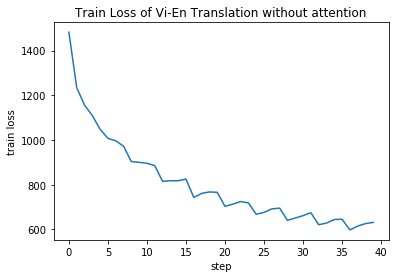

In [42]:

fig = plt.figure()
plt.plot(train_loss_history)

plt.xlabel('step')
plt.ylabel('train loss')
plt.title('Train Loss of Vi-En Translation without attention')
plt.show()
fig.savefig('train_loss_vi_10.png')

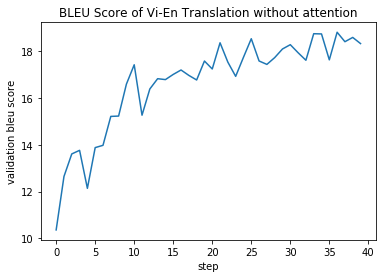

In [44]:

fig = plt.figure()
plt.plot(validation_score_history)
plt.xlabel('step')
plt.ylabel('validation bleu score')
plt.title('BLEU Score of Vi-En Translation without attention')
fig.savefig('val_score_vi_10.png')

plt.show()

In [45]:

encoder.load_state_dict(torch.load('vi_encoder_10.pt'))
decoder.load_state_dict(torch.load('vi_decoder_10.pt'))
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (dropout): Dropout(p=0.3)
  (embedding): Embedding(30004, 300)
  (gru): GRU(812, 512)
  (out): Linear(in_features=512, out_features=30004, bias=True)
  (softmax): LogSoftmax()
)

In [46]:
decoded_words,input_words, target_words, score = evaluate(encoder, decoder, test_loader)

bleu score:  21.00726720202513


In [47]:
for i in range(len(decoded_words)):
    print('input: ', input_words[i])
    print('target: ', target_words[i])
    print('predict: ', decoded_words[i])
    print('-----------------------------------------------')
    print()

input:  ['tôi', 'muốn', 'rút', 'về', 'cái', 'lề_thói', 'hàng_ngày', 'và', 'sự', 'dễ_chịu', 'của', 'cuộc_sống', 'trong', 'khu', 'ngoại_ô', 'không_ai', 'hay_biết', 'người', 'bà', 'người', 'mẹ', 'và', 'hai', 'con_gái', 'kết_thúc', 'mỗi', 'ngày', 'như', 'bao', 'ngày', 'trong_suốt', 'năm', 'kể', 'cho', 'nhau', 'nghe', 'chuyện', 'trong', 'ngày', '<EOS>']
target:  ['i', 'wanted', 'to', 'retreat', 'to', 'the', 'routines', 'and', 'comfort', 'of', 'life', 'in', 'an', '<UNK>', 'suburb', 'a', 'grandmother', 'a', 'mother', 'and', 'two', 'daughters', 'ending', 'each', 'day', 'as', 'they', 'had', 'for', 'almost', 'years', 'telling', 'one', 'another', 'the', 'story', 'of', 'their', 'day', '<EOS>']
predict:  ['i', 'wanted', 'to', 'understand', 'the', 'story', 'of', 'the', 'mystic', 'and', 'the', 'gesture', 'of', 'the', 'everyday', 'and', 'the', 'mother', 'of', 'the', 'mother', 'and', 'the', 'mother', 'of', 'the', 'mother', 'and', 'the', 'mother', 'was', 'a', 'mother', 'and', 'she', 'was', 'able', 'to',

target:  ['we', 'have', 'a', 'system', 'of', 'justice', 'in', 'this', 'country', 'that', 'treats', 'you', 'much', 'better', 'if', 'you', 're', 'rich', 'and', 'guilty', 'than', 'if', 'you', 're', 'poor', 'and', 'innocent', '.', '<EOS>']
predict:  ['we', 'have', 'a', 'strong', 'system', 'with', 'a', 'good', 'system', 'if', 'you', 're', 'willing', 'to', 'get', 'married', 'with', 'the', 'poor', 'and', 'you', 're', 'not', 'disappointed', '.', '<EOS>']
-----------------------------------------------

input:  ['bằng', 'nhiều', 'cách', 'chúng_ta', 'được', 'dạy', 'để', 'tin', 'rằng', 'câu_hỏi', 'thực_sự', 'là', 'liệu', 'người_ta', 'có', 'đáng', 'phải', 'chết', 'vì', 'tội_lỗi', 'mà', 'họ', 'đã', 'gây', 'ra', '?', '<EOS>']
target:  ['in', 'many', 'ways', 'we', 've', 'been', 'taught', 'to', 'think', 'that', 'the', 'real', 'question', 'is', 'do', 'people', 'deserve', 'to', 'die', 'for', 'the', 'crimes', 'they', 've', 'committed', '?', '<EOS>']
predict:  ['how', 'many', 'we', 'taught', 'to', 'believ

-----------------------------------------------

input:  ['tôi', 'nói', 'rất', 'nhiều', 'về', 'những', 'vấn_đề', 'này', '<EOS>']
target:  ['i', 'talk', 'a', 'lot', 'about', 'these', 'issues', '.', '<EOS>']
predict:  ['i', 'm', 'talking', 'about', 'these', 'issues', '.', '<EOS>']
-----------------------------------------------

input:  ['năm', 'đã', 'có', '.', 'người', 'bị', 'tù', '<EOS>']
target:  ['in', 'there', 'were', 'people', 'in', 'jails', 'and', 'prisons', '.', '<EOS>']
predict:  ['and', 'there', 'was', 'a', 'prison', '.', '<EOS>']
-----------------------------------------------

input:  ['nhưng', 'điều', 'này', 'lại', 'khiến', 'tôi', 'quan_tâm', '<EOS>']
target:  ['it', 's', 'interesting', 'to', 'me', '.', '<EOS>']
predict:  ['but', 'it', 's', 'me', 'to', 'make', 'myself', '.', '<EOS>']
-----------------------------------------------

input:  ['chúng', 'ta', 'không', 'muốn', 'nói', 'về', 'lịch_sử', '<EOS>']
target:  ['we', 'don', 't', 'like', 'to', 'talk', 'about', 'our', 'hist

predict:  ['and', 'that', 's', 'simply', 'because', 'i', 'm', 'going', 'to', 'tell', 'you', 'a', 'story', 'about', 'the', 'next', 'year', 'i', 'will', 'tell', 'you', 'how', 'to', 'lose', 'the', 'story', '.', '<EOS>']
-----------------------------------------------

input:  ['câu_chuyện', 'nho_nhỏ', 'thứ', 'của', 'tôi', 'đó', 'là', 'khi', 'tôi', 'đang', 'là', 'người', 'đồng', 'thực_hiện', 'đưa_vào', 'giới_thiệu', 'phương_thức', 'đánh_cá', 'kéo', 'lưới', 'từ', 'đuôi', 'thuyền', 'tại', 'đông_nam_á', '<EOS>']
target:  ['my', 'third', 'little', 'story', 'is', 'that', 'i', 'was', 'an', 'accomplice', 'in', 'the', 'introduction', 'of', 'trawling', 'in', 'southeast', 'asia', '.', '<EOS>']
predict:  ['my', 'second', 'story', 'is', 'that', 'when', 'i', 'was', 'a', 'man', 'who', 'was', 'working', 'on', 'the', 'ground', 'of', 'the', 'vessel', 'that', 'was', 'built', 'by', 'the', 'fishermen', 'of', 'the', 'road', '.', '<EOS>']
-----------------------------------------------

input:  ['câu_chuyện', '

target:  ['well', 'because', 'they', 'don', 't', 'know', 'that', 'it', 'was', 'different', '.', '<EOS>']
predict:  ['because', 'they', 'weren', 't', 'quite', 'aware', 'it', 'was', 'all', '.', '<EOS>']
-----------------------------------------------

input:  ['bạn', 'chỉ', 'mất', 'đi', 'những', 'động_vật', 'quý_hiếm', '<EOS>']
target:  ['you', 'always', 'lose', 'rare', 'animals', '.', '<EOS>']
predict:  ['you', 'just', 'lose', 'the', 'animals', '.', '<EOS>']
-----------------------------------------------

input:  ['nó', 'vẫn', 'chưa', 'bị', '<UNK>', '<EOS>']
target:  ['it', 'was', 'not', 'drowned', 'yet', '.', '<EOS>']
predict:  ['it', 's', 'not', 'been', '.', '<EOS>']
-----------------------------------------------

input:  ['cám_ơn', 'rất', 'nhiều', '<EOS>']
target:  ['thank', 'you', 'very', 'much', '.', '<EOS>']
predict:  ['thank', 'you', 'very', 'much', '.', '<EOS>']
-----------------------------------------------

input:  ['bây_giờ', 'không', 'bàn', 'về', 'lựa_chọn', 'mua', 'chai'

input:  ['bây_giờ', 'cùng', 'bệnh_nhân', 'bị', 'đau_ngực', 'ấy', 'giả_dụ', 'anh', 'ta', 'ướt', 'mồ', 'hồi', 'và', 'nói', 'lắm', 'và', 'thêm', 'tí', 'mùi', 'cồn', 'vào', 'hơi_thở', 'của', 'anh', 'ta', 'và', 'đột_nhiên', 'tiền_sử', 'bệnh', 'của', 'tôi', 'bị', 'ảnh_hưởng', 'xấu', '<EOS>']
target:  ['now', 'take', 'the', 'same', 'patient', 'with', 'chest', 'pain', 'make', 'them', 'moist', 'and', '<UNK>', 'and', 'put', 'a', 'little', 'bit', 'of', 'alcohol', 'on', 'their', 'breath', 'and', 'suddenly', 'my', 'history', 'is', '<UNK>', 'with', 'contempt', '.', '<EOS>']
predict:  ['now', 'he', 's', 'suffering', 'his', 'teeth', 'he', 's', 'got', 'to', 'get', 'sick', 'and', 'he', 's', 'got', 'to', 'eat', 'his', 'teeth', 'and', 'he', 's', 'got', 'worse', 'and', 'he', 's', 'wrong', 'and', 'he', 's', 'wrong', 'at', 'the', 'end', 'of', 'my', 'stress', '.']
-----------------------------------------------

input:  ['và', 'tôi', 'muốn', 'được', 'nói', 'với', 'các', 'bạn', 'rằng', 'những', 'sai_lầm', 'tệ_

predict:  ['because', 'the', 'viewer', 'who', 'creates', 'us', 'to', 'us', 'like', 'that', 'staircase', 'and', 'creates', 'us', 'to', 'make', 'a', 'better', 'audience', 'to', 'the', 'big', 'ones', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'thế_là', 'sau_đó', 'cộng_đồng', 'này', 'được', 'tạo', 'ra', 'từ', 'những', 'người', 'biết', 'đến', 'câu_chuyện', 'cười', 'này', 'và', 'họ', 'bắt_đầu', 'nói', 'và', 'làm', 'một_số', 'điều', 'về', 'nó', '.', '<EOS>']
target:  ['and', 'so', 'then', 'this', 'community', 'formed', 'of', 'people', 'who', 'shared', 'this', 'big', 'inside', 'joke', 'and', 'they', 'started', 'talking', 'about', 'it', 'and', 'doing', 'things', 'with', 'it', '.', '<EOS>']
predict:  ['and', 'so', 'this', 'is', 'the', 'way', 'that', 'these', 'people', 'have', 'been', 'known', 'to', 'know', 'about', 'this', 'and', 'they', 'started', 'to', 'know', 'about', 'this', 'and', 'they', 'started', 'to', 'know', 'it', '.', '<EOS>']
-----------------------

predict:  ['and', 'the', 'oil', 'spill', 'started', 'to', 'start', 'and', 'oil', '.', '<EOS>']
-----------------------------------------------

input:  ['trạng_thái', 'mới', 'mà', 'thế_giới', 'đang', 'hướng', 'tới', 'là', 'gì', '?', '<EOS>']
target:  ['what', 's', 'that', 'new', 'state', 'that', 'the', 'world', 'is', 'heading', 'toward', '?', '<EOS>']
predict:  ['what', 'is', 'the', 'world', 'in', 'the', 'world', 'that', 'are', 'coming', 'to', '?', '<EOS>']
-----------------------------------------------

input:  ['và', 'chúng', 'không', 'cho', 'chúng_ta', 'biết', 'nhiều', 'lắm', '.', '<EOS>']
target:  ['and', 'they', 'don', 't', 'tell', 'us', 'much', '.', '<EOS>']
predict:  ['and', 'they', 'don', 't', 'know', 'us', 'know', '.', '<EOS>']
-----------------------------------------------

input:  ['đó', 'là', 'tất_cả', 'những', 'gì', 'có_thể', 'xảy', 'ra', '.', '<EOS>']
target:  ['that', 's', 'about', 'all', 'it', 'can', 'do', '.', '<EOS>']
predict:  ['that', 's', 'all', 'the', 'things', 

input:  ['và', 'chúng', 'đều', 'liên_kết', 'chúng_ta', 'thành', 'một', 'cộng_đồng', 'lớn', 'hơn', 'nhanh', 'hơn', 'và', 'có', 'khả_năng', 'tiến_hoá', 'xa', 'hơn', 'chúng_ta', 'trước_đây', '.', '<EOS>']
target:  ['and', 'it', 'all', 'connects', 'us', 'together', 'into', 'something', 'that', 'is', 'much', 'bigger', 'and', 'much', 'faster', 'and', 'able', 'to', 'evolve', 'than', 'what', 'we', 'were', 'before', '.', '<EOS>']
predict:  ['and', 'they', 're', 'all', 'connected', 'into', 'a', 'faster', 'and', 'we', 're', 'capable', 'of', 'the', 'ecosystem', 'that', 'we', 're', 'capable', 'and', 'far', 'far', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'tôi', 'nghĩ', 'rằng', 'đó', 'là', 'thứ', 'mà', 'chúng_ta', 'đang', 'thấy', 'ở', 'đây', 'trong', 'sự', 'bùng_nổ', 'của', 'đường_cong', 'này', '.', '<EOS>']
target:  ['and', 'i', 'think', 'that', 'that', 's', 'what', 'we', 're', 'seeing', 'here', 'in', 'this', 'explosion', 'of', 'curve', '.', '<EOS>']
predict:  ['

predict:  ['and', 'i', 'think', 'that', 's', 'really', 'important', 'that', 'we', 'don', 't', 'have', 'to', 'lose', 'the', 'word', '.', '<EOS>']
-----------------------------------------------

input:  ['họ', 'sử_dụng', 'đôi', 'bàn_tay', 'của', 'mình', 'để', 'viết', 'lên', 'những', 'ứng_dụng', 'giúp', 'chính_phủ', 'làm_việc', 'tốt', 'hơn', '.', '<EOS>']
target:  ['they', 're', 'using', 'their', 'hands', 'to', 'write', 'applications', 'that', 'make', 'government', 'work', 'better', '.', '<EOS>']
predict:  ['they', 'used', 'to', 'write', 'their', 'own', 'version', 'to', 'write', 'their', 'own', 'better', '.', '<EOS>']
-----------------------------------------------

input:  ['nếu', 'chúng_ta', 'muốn', 'chính_quyền', 'làm_việc', 'cho', 'mình', 'chúng_ta', 'phải', 'khiến', 'cho', 'hệ_thống', 'đó', 'trở_nên', 'hấp_dẫn', '.', '<EOS>']
target:  ['if', 'we', 'want', 'this', 'institution', 'to', 'work', 'for', 'us', 'we', 're', 'going', 'to', 'have', 'to', 'make', 'bureaucracy', 'sexy', '.', '<

predict:  ['so', 'the', 'first', 'principle', 'is', 'that', 'the', 'images', 'of', 'the', 'form', 'is', 'a', 'picture', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'đây', 'là', 'những', 'gì', 'chúng_tôi', 'đã', 'làm', 'chúng_tôi', 'đã', 'sử_dụng', 'giải_pháp', 'đám_đông', 'ở', 'hà_lan', '<EOS>']
target:  ['so', 'what', 'we', 'did', 'we', 'crowdsourced', 'the', 'netherlands', '.', '<EOS>']
predict:  ['and', 'this', 'is', 'what', 'we', 'decided', 'to', 'do', 'in', 'the', 'township', 'in', 'the', 'situation', '.', '<EOS>']
-----------------------------------------------

input:  ['những', 'tấm', 'ảnh', 'như', 'thế_này', 'việc', 'xây_dựng', 'diễn', 'ra', 'dọc', 'theo', 'con_đường', 'đông_đúc', '.', '<EOS>']
target:  ['photos', 'like', 'this', 'construction', 'going', 'on', 'along', 'a', 'busy', 'road', '.', '<EOS>']
predict:  ['these', 'images', 'are', 'happening', 'in', 'the', 'space', 'of', 'the', 'ground', '.', '<EOS>']
---------------------------------